Hierarchical 에이전트 시스템-문서기반으로 팟캐스트 시스템 만들기

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# pip install pydub

In [3]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information. """
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f"n{doc.page_content}\n" for doc in docs
        ]
    )


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# Using OpenAI TTS API
from openai import OpenAI
from pathlib import Path

@tool
def text_to_speech(text:str, voice:str, output_filename: str) -> str:
    """
    Converts text to speech using OpenAI's TTS API, saving the audio file locally with a dynamic filename.

    Args:
        text (str): The target text to convert to speech
        voice (str): The voice model to use for speech synthesis. Options include: -'alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer'.
        output_filename (str): The output audio file which is converted from target text, including file extension. (e.g. 'output.mp3').
    """
    client = OpenAI()
    speech_file_path =Path(output_filename)
    response = client.audio.speech.create(model="tts-1-hd", voice=voice, input=text)
    response.stream_to_file(speech_file_path)
    return str(speech_file_path)

주이전 여러 Segment 별 오디오 트랙을 하나의 오디오 파일로 만드는 도구

In [5]:
from pydub import AudioSegment

@tool
def edit_podcast_audio(segments: List[str], pauses_between_sagments: int = 100, output_filename: str = "final_podcast_episode.mpe") -> str:
    """
    Create a podcast episode by combinging audio segments with specified pauses between them, ensuring consistent volume.

    Args:
        segments (List[str]): List of paths of audio segment files:
        pauses_between_segments (int): Duration of pause between segments in milliseconds. Default is 1000
        output_filename (str): The name for the output podcast file, including file extension (e.g. 'episode.mp3').

    Return:
        str: The path to the saved podcast episode file.
    """
    podcast_episode = AudioSemgent.silent(duration=0)

    for segment_path in segments:
        segment = AudioSegment.from_file(segment_path)
        podcast_episode += segment + AudioSegment.silent(duration=pauses_between_segments)
    
    podcast_episode = podcast_episode.normalize() # Normalize volume
    podcast_episode.export(output_filename, format="mp3")

    return output_filename

/home/user/langchain-kr/myenv/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [6]:

tools = [
    tavily_tool,
    scrape_webpages,
    text_to_speech,
    edit_podcast_audio,
]

In [7]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """ A LLM-based router. """
    options = ["FINISH"] + members
    print(options)
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]).partial(options=str(options), team_members=", ".join(members))
    print("Research Team is created !!!!")
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

Researh Team

In [8]:
import functools
import operator
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]

    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision    
    next: str

llm = ChatOpenAI(model="gpt-4o-mini")

search_system = """
You are a search specialist in a research team. Your role is to use the Tavily search tool to find relevant and up-to-date information
on the given topic to generate the podcast. 

Your tasks:
1. Analyze the user's rquest or question.
2. Formulate effective search queries based on the request.
3. Use the Tavily search tool to find information.
4. Summarize the most relevant findings concisely.
5. If the search results are insufficient, consider refining your search query and trying again.

Always strive for accuracy and relevance in your search results.
If you can't find satisfactory information, be honest about the limitations of your search.
"""

search_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=search_system)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

webscraper_system = """
You are a web scraping specialist in a research team.
Your role is to extract detailed information from specific web pages using scrape_webpages tool.

Your tasks:
1. Analyze the URLs or web pages provided, usually as a result of the Search agent's findings.
2. Use the scrape_webpages tool to extract relvant content from these pages.
3. Process adn summarize the scraped content, focusing on the most pertinent information related to the research topic.
4. If the scraped content is not satisfactory, consider requesting different URLs from the Search agent or suggesting refinements to the search query.

Ensure that you respect website terms of service and ethical scraping practices. Always summarize the contextualize the information you scrape, don't justify.
"""
research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier=webscraper_system)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")


supervisor_agent = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing a conversation between the following workers:
    Search: A search specialist who uses the Tavily search tool to find relevant information.
    WebScraper: A web scraping specialist who extracts detailed information from web pages.
    Given the following user request, respond with the worker to act next.
    Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.""",
    ["Search", "WebScraper"],
)


['FINISH', 'Search', 'WebScraper']
Research Team is created !!!!


/tmp/ipykernel_196/2663850324.py:46: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [9]:

research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)

research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()

# 상위 그래프와 하위 그래프의 연결
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | chain

In [10]:
# from util import display_graph
# display_graph(research_chain)

In [11]:
# Test
# initial_state: ResearchTeamState = {  # Type the initial state
#     "messages": [HumanMessage(content="DeepSeek meaning in Technology and Economics.")],
#     "team_members": ["Search", "WebScraper"],  # Important: Initialize team members
#     "next": None,  # Initialize 'next'
# }

# for s in chain.stream(initial_state, {"recursion_limit": 5}): # Pass the TypedDict
#     if "__end__" not in s:
#         print(s)
#         print('-----')

{'supervisor': {'next': 'Search'}}
-----
{'Search': {'messages': [HumanMessage(content='### Summary of Findings on "DeepSeek"\n\n**In Technology:**\nDeepSeek is an emerging open-source AI model developed by a Chinese startup, challenging the dominance of established Western tech giants like OpenAI, Microsoft, Meta, and Google. Launched in late 2023, DeepSeek\'s models offer significant capabilities at a fraction of the cost, with reports stating that it achieved superior results with only $6 million in investment versus the hundreds of millions spent by competitors. This disruption is expected to transform the business models of the tech industry, emphasizing affordability and accessibility in AI technology. Furthermore, DeepSeek\'s competitive pricing threatens the traditional revenue structure, which relies on proprietary technology and subscription models.\n\nKey points include:\n- DeepSeek\'s open-source approach increases competitiveness and accessibility in AI development.\n- It 

GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

Podcast Team 정의

In [12]:
class PodcastTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    script: List[dict]
    audio_segments: List[str]

podcast_plan_system="""
You are tasked with creating a structured script for a podcast episode.
The script should consist of series of interactions between the host and the guest based on the provided topic and information from the research.
IMPORTANT NOTE: The podcast sholud have 2 or more speakers to have a conversation.

For each part of the dialogue, clearly specify whether it's the host speaking or the guest. Also, assign a suitable voice model for text-to-speach conversation.

- Host segments: Use the 'alloy' voice model.
- Guest segmetns: Use the 'fable' voice model.

The output should be a list where each item is a dictionary with keys 'speaker', 'text', and 'voice', indicating the speaker (host or geust)

Example output format:
[
    {"speaker"}: "host", "text": "Welcome to our podcast, where we explore the lastest in technology.", "voice": "alloy"},
    {"speaker"}: "guest", "text": "Thank you for inviting me, it's great to be here to share my experiences.", "voice": "fable"},
    {"speaker"}: "host", "text": "Can you tell us about your current project?", "voice": "alloy"},
    {"speaker"}: "guest", "text": "Certainly! I've bean working on a new AI platform that...", "voice": "fable"},
    ...
]

Your taks is to generate a similar structured script in **KOREAN**, ensuring each dialogue segment between the host and guest is well-defined and allocating balanced.
"""

podcast_planner_agent = create_react_agent(
    llm, state_modifier=podcast_plan_system, tools=[tavily_tool]
)

podcast_planner_node = functools.partial(agent_node, agent=podcast_planner_agent, name="PodcastPlanner")

audio_producer_system="""
You are resonsible for producing the final audio for the podcast episode. Take the structured script provided by the Podcast Planner, which contains seqments. 
For each segment, use the 'text_to_speech' tool to generate audio, specifying the 'text' and 'voice' as provided. 
Ensure each segment is saved as a seperated audio file. After generating all segments, use the 'edit_podcast_audio' tool to combine there audio files 
into on one seamless podcast episode. The audio files should be combined in the order they are provided in the script, with appropriate pauses between segments
to simulate a natural conversation.

Your ouptput sholud be the path to the final combined podcast episode audio file.
"""

audio_producer_agent = create_react_agent(
    llm, [text_to_speech, edit_podcast_audio], state_modifier=audio_producer_system
)
audio_producer_node = functools.partial(agent_node, agent=audio_producer_agent, name="AudioProducer")

podcast_supervisor = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the podcast creation process.
    Your team consists of a PodcastPlanner and an AudioProducer.
    Given the current state, decide which team member should act next or if the process is complete.
    Respond with 'PodcastPlanner', 'AudioProducer', or 'FINISH', """,
    ["PodcastPlanner", "AudioProducer"]
)

['FINISH', 'PodcastPlanner', 'AudioProducer']
Research Team is created !!!!


In [13]:
podcast_graph = StateGraph(PodcastTeamState)
podcast_graph.add_node("PodcastPlanner", podcast_planner_node)
podcast_graph.add_node("AudioProducer", audio_producer_node)
podcast_graph.add_node("supervisor", podcast_supervisor)

podcast_graph.add_edge(START, "supervisor")
podcast_graph.add_edge("PodcastPlanner", "supervisor")
podcast_graph.add_edge("AudioProducer", "supervisor")
podcast_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"PodcastPlanner": "PodcastPlanner", "AudioProducer": "AudioProducer", "FINISH": END},
)

chain = podcast_graph.compile()

# 상위 그래프와 하위 그래프의 연결
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["PodcastPlanner", "AudioProducer"],
        "next": "",
        "script": [],
        "audio_segments": []
    }
    return results

podcast_chain = enter_chain | chain

In [14]:
display_graph(podcast_chain)

NameError: name 'display_graph' is not defined

상위 레이어의 Supervisor 정의하기

In [15]:
supervisor_node = create_team_supervisor(
    llm,
    """
    You are a supervisor tasked with managing a conversation between the following teams: {team_members}.
    Given the following user request, respond with the worker to act next. 
    Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.
    """,
    ["ResearchTeam", "PodcastTeam"],
)

['FINISH', 'ResearchTeam', 'PodcastTeam']
Research Team is created !!!!


In [16]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response:dict):
    return {"messages": [response["messages"][-1]]}

super_graph = StateGraph(State)
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node("PodcastTeam", get_last_message | podcast_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

super_graph.add_edge(START, "supervisor")
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PodcastTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PodcastTeam": "PodcastTeam", "ResearchTeam": "ResearchTeam", "FINISH": END
    }
)
super_graph = super_graph.compile()


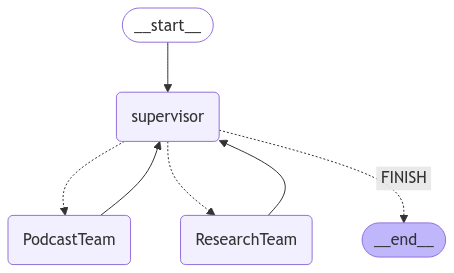

In [ ]:
display_graph(super_graph)

In [17]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="DeepSeek meaning in Technology and Economic"
            )
        ]
    },
    {"recursion_limit": 150}
):
    if "__end__" not in s:
        print(s)
        print('-----')

{'supervisor': {'next': 'ResearchTeam'}}
-----
{'ResearchTeam': {'messages': [HumanMessage(content="### Summary of DeepSeek's Impact in Technology and Economy\n\n**1. In Technology:**\n- **Overview**: DeepSeek, a startup established in May 2023 in Hangzhou, China, has quickly emerged as a significant player in AI, especially with its open-source large language models (LLMs). Its first model, R1, launched in January 2025, is touted for its efficiency and cost-effectiveness, reportedly developed at a fraction of the investment seen by major Western firms.\n  \n- **Technological Innovations**:\n  - DeepSeek utilizes advanced architectures such as a **Mixture-of-Experts** and **Multi-Head Latent Attention**, which allow it to activate only the necessary parameters for tasks, enhancing performance while reducing resource consumption.\n  - The company’s models can outperform competitors' systems like OpenAI's GPT-4 in capabilities while costing significantly less — around **$6 million** comp

/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, t

{'PodcastTeam': {'messages': [HumanMessage(content="I apologize for the ongoing issues with the podcast editing process. Unfortunately, I'm unable to resolve the audio editing errors at this moment. \n\nHowever, you do have all the individual audio segments generated. You might consider combining them using audio editing software like Audacity or GarageBand, where you can import the individual files and add the necessary pauses manually.\n\nOnce again, I'm sorry for the inconvenience caused, and if there's anything else you need, please feel free to ask!", additional_kwargs={}, response_metadata={}, name='AudioProducer')]}}
-----
{'supervisor': {'next': 'PodcastTeam'}}
-----


/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)
/tmp/ipykernel_196/3535289669.py:18: DeprecationWarning: Due to a bug, t

{'PodcastTeam': {'messages': [HumanMessage(content='It seems that there\'s a persistent issue with combining the audio segments into a single podcast episode file. Since you mentioned considering using audio editing software, it might be best to proceed with that option.\n\nI recommend downloading the generated segments "segment1.mp3", "segment2.mp3", and "segment3.mp3". You can import these into Audacity, GarageBand, or any audio editing software of your choice to combine them with the desired pauses manually.\n\nIf you need any further assistance or additional audio segments, please let me know!', additional_kwargs={}, response_metadata={}, name='AudioProducer')]}}
-----
{'supervisor': {'next': 'FINISH'}}
-----
